## Prediction of region based on country data with Adaptive Boost 

This work is devoted to analysis of the impact of outliers on the accuracy of Classifier with Adaboost.

Adaboost increase the weights of misclassified points on each iteration and therefore might put high weights on these outliers as they tend to be often misclassified, so that the new classifier focuses on them more.
The penalties for misclassification grow exponentially with the magnitude of the predictive function output. 

This can become an issue and one outlier could have a very strong impact on the final model.

Let's start with loading libraries and preprocess the data.

In [25]:
# Load libraries
from sklearn.ensemble import AdaBoostClassifier
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import warnings
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'svg'

In [26]:
# initial dataset
dataset = pd.read_csv('countries.csv',sep=',')
dataset.head(10)

,Country,Region,Population,Area (sq. mi.),Pop. Density (per sq. mi.),Coastline (coast/area ratio),Net migration,Infant mortality (per 1000 births),Literacy (%),Phones (per 1000),Arable (%),Crops (%),Other (%),Climate,Birthrate,Deathrate,Agriculture,Industry,Service,GDP ($ per capita)
0,Afghanistan,ASIA,31056997,647500,48.0,0.00,23.06,163.07,36.0,3.2,12.13,0.22,87.65,1.0,46.60,20.34,0.38,0.24,0.38,700.0
1,Albania,EUROPE,3581655,28748,124.6,1.26,-4.93,21.52,86.5,71.2,21.09,4.42,74.49,3.0,15.11,5.22,232.00,188.00,579.00,4500.0
2,Algeria,AFRICA,32930091,2381740,13.8,0.04,-0.39,31.00,70.0,78.1,3.22,0.25,96.53,1.0,17.14,4.61,101.00,0.60,298.00,6000.0
3,American Samoa,OCEANIA,57794,199,290.4,58.29,-20.71,9.27,97.0,259.5,10.00,15.00,75.00,2.0,22.46,3.27,NaN,NaN,NaN,8000.0
4,Andorra,EUROPE,71201,468,152.1,0.00,6.60,4.05,100.0,497.2,2.22,0.00,97.78,3.0,8.71,6.25,NaN,NaN,NaN,19000.0
5,Angola,AFRICA,12127071,1246700,9.7,0.13,0.00,191.19,42.0,7.8,2.41,0.24,97.35,NaN,45.11,24.20,96.00,658.00,246.00,1900.0
6,Anguilla,AMERICA,13477,102,132.1,59.80,10.76,21.03,95.0,460.0,0.00,0.00,100.00,2.0,14.17,5.34,0.04,0.18,0.78,8600.0
7,Antigua & Barbuda,AMERICA,69108,443,156.0,34.54,-6.15,19.46,89.0,549.9,18.18,4.55,77.27,2.0,16.93,5.37,38.00,0.22,743.00,11000.0
8,Argentina,AMERICA,39921833,2766890,14.4,0.18,0.61,15.18,97.1,220.4,12.31,0.48,87.21,3.0,16.73,7.55,95.00,358.00,547.00,11200.0
9,Armenia,EUROPE,2976372,29800,99.9,0.00,-6.47,23.28,98.6,195.7,17.55,2.30,80.15,4.0,12.07,8.23,239.00,343.00,418.00,3500.0


In [27]:
# check for missing values
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227 entries, 0 to 226
Data columns (total 20 columns):
Country                               227 non-null object
Region                                227 non-null object
Population                            227 non-null int64
Area (sq. mi.)                        227 non-null int64
Pop. Density (per sq. mi.)            227 non-null float64
Coastline (coast/area ratio)          227 non-null float64
Net migration                         224 non-null float64
Infant mortality (per 1000 births)    224 non-null float64
Literacy (%)                          209 non-null float64
Phones (per 1000)                     223 non-null float64
Arable (%)                            225 non-null float64
Crops (%)                             225 non-null float64
Other (%)                             225 non-null float64
Climate                               205 non-null float64
Birthrate                             224 non-null float64
Deathrate       

### Fill numerical NaNs

This dataset contains missing values. 
A standard and often very good approach is to replace the missing values with mean, median or mode. 
For numerical values we should go with mean.

In [28]:
# fill all NaNs with mean
dataset.fillna(dataset.mean(), inplace=True)

Our goal is to classify Europe region based on country data, so we need to devide our features and target value.

In [29]:
# devide features
X = dataset.drop(columns=["Region", 'Country']) 
y = dataset["Region"]

For classification model all features must be numerical.
The code below replaces categorical target values with numerical - 0 or 1.

In [30]:
# replace categorical target with numerical 0,1
for i in range(len(y)):
    if y[i] != 'EUROPE':
        y[i] = 0
    else:
        y[i] = 1

# change the type of target variable
y  = y.astype(int)

For spliting dataset into test and train samples, I decided to use K-Fold Cross validation.
The advantage of K-Fold Cross validation is that all the examples in the dataset are eventually used for both training and testing. 

Decision tree classifer with depth=1(decision stump) was chosen as weak learner in AdaBoostClassifier because it is very simple and algorithm is much less prone to overfitting.

For every data split we got an accuracy score of Adaboost-decision tree classifer object.

Finally, the true accuracy is estimated as the average accuracy. 

In [31]:
kf = KFold(n_splits=15)
kf.get_n_splits(X)
X_d = X.values

accur = []
for train_index, test_index in kf.split(X_d):
    X_train, X_test = X_d[train_index], X_d[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # Create adaboost-decision tree classifer object with DecisionTreeClassifier
    model = AdaBoostClassifier(n_estimators=50,algorithm='SAMME',
                         learning_rate=1,
                         random_state=0)
    # Train model
    model = model.fit(X_train, y_train)
    accur.append(model.score(X_test, y_test))

# Final accuracy
accur_mean = (sum(accur)/len(accur))
print( "AdaBoost accuracy with outliers: ", accur_mean )

AdaBoost accuracy with outliers:  0.9383333333333334


Now we got our accuracy score of AdaBoost Classifier. It is not very high and it seems that initial dataset has outliers.

From AdaBoost algorithm we know that if an outlier is hard to classify correctly, the outlier will accumulate a lot of weight. 
Then the classifier will give a high priority to that point and classify it correctly. This might mean that all the other points will be misclassified. However, this classifier's decision will not be so important to us in the end because the only one point which was classified correctly is the outlier. 
That's why we need to remove outliers. To do that we can just find the points with very large weight.

For every classificator in our AdaBoost algorithm we can get prediction and then calculate alpha on every step via the formula:



\begin{equation}
  \alpha_{i}=\begin{cases}
    \alpha_{i}*e^{-w_{t}}, & \text{if $f_{i}(x_{i})=y_{i}$}.\\
    \alpha_{i}*e^{w_{t}}, & \text{if $f_{i}(x_{i})\neq y_{i}$}
  \end{cases}
\end{equation}



The coefficients $w_{t}$  for calculation alphas from our model:

In [32]:
model.estimator_weights_

array([2.2617631 , 1.34132853, 1.61857433, 0.80836907, 1.07049365,
       1.05239672, 0.94024423, 0.7542557 , 1.20329988, 0.85054259,
       1.12214974, 0.81995823, 0.99789889, 0.65267792, 0.92483419,
       1.03183467, 1.1540099 , 0.87873097, 0.74918118, 0.75649543,
       0.60149499, 0.78762402, 0.60789535, 1.02198418, 0.65789006,
       0.8147989 , 0.96225636, 0.4615409 , 0.45284081, 0.61233084,
       0.68001844, 0.45685111, 0.57068066, 0.48923148, 0.59012328,
       0.89716698, 0.61347792, 0.50195628, 0.79579577, 0.83659606,
       0.79078512, 0.71062124, 0.80298749, 0.53035759, 0.94926247,
       0.74639381, 0.62972363, 0.73400862, 0.47189255, 0.58833425])

In [33]:
# initialize alpha array with 1/m 
alpha = [1/len(X) for i in range(len(X))]

# for every classificator in our AdaBoost algorithm we can get prediction and then calculate alpha for every step
for e, est in enumerate(model.estimators_):
    y_pred = est.predict(X)
    for i in range(len(y_pred)):
        if y.iloc[i] == y_pred[i]:
            alpha[i] = alpha[i]*np.exp(-model.estimator_weights_[e])
        else:
            alpha[i] = alpha[i]*np.exp(model.estimator_weights_[e])

If $x_{i}$ often mistakes, weight of $\alpha_{i}$ gets very large and vice-versa if $x_{i}$ often correct, weight of $\alpha_{i}$ gets very small.
This can cause numerical instability after many iterations.
That's why last thing to do with alpha is normalizing them.

Eventually our array with alphas looks like this:

In [34]:
alpha = alpha/sum(alpha) 

Now we can determine outliers in array of alphas.

The official definition of an outlier is either below the (first quartile minus 1.5 times the Interquartile Range (IQR)) or above the (third quartile plus 1.5 times the IQR):

lower bound < first quartile−1.5 x IQR

higher bound > third quartile+1.5 * IQR

My approach will be to get the array of indexes of outlying features. I will then easilly remove these indexes from initial dataset.

Firstly, let's draw boxplot of alphas to better understand the existence of outliers.

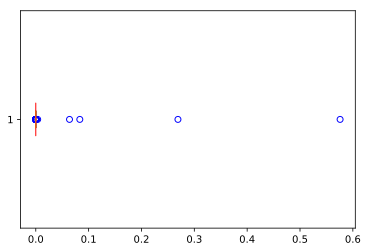

In [35]:
# boxplot of alphas
plt.boxplot(alpha, notch=True, patch_artist=True,
            boxprops=dict(facecolor='red', color='red'),
            flierprops=dict(color='blue', markeredgecolor='blue'),
            vert=False
            )
plt.show()

In [36]:
#function of outliers detection
def get_outliers(arr):
    Q1, Q3 = np.percentile(arr, [25, 75])
    IQR = Q3 - Q1
    lower = Q1 - (IQR * 1.5)
    upper = Q3 + (IQR * 1.5)
    return np.where([((arr > upper) | (arr < lower))][0])

The array of indexes of outlying features:

In [37]:
alpha = np.array(alpha)
res = get_outliers(alpha)
res[0]

array([  1,  13,  14,  17,  22,  25,  26,  36,  50,  66,  78,  80,  88,
        93,  94,  98, 101, 103, 106, 112, 116, 129, 130, 145, 146, 149,
       170, 172, 174, 176, 193, 197, 199, 204, 206, 207, 213, 214, 215,
       216, 219, 222, 223])

We can drop these outliers from our initial dataset.

In [38]:
X_wo = X.drop(res[0])
y_wo = y.drop(res[0])
y_wo = np.array(y_wo)

And use Kfold cross validation one more time to get new accuracy on dataset without outliers

In [39]:
kf = KFold(n_splits=15)
kf.get_n_splits(X_wo)
X_d = X_wo.values  
accur_wo = []
for train_index, test_index in kf.split(X_d):
    X_train, X_test = X_d[train_index], X_d[test_index]
    y_train, y_test = y_wo[train_index], y_wo[test_index]
    # Create adaboost-decision tree classifer object with DecisionTreeClassifier
    clf = AdaBoostClassifier(n_estimators=50,algorithm='SAMME',
                         learning_rate=1,
                         random_state=0)
    # Train model
    model = clf.fit(X_train, y_train)
    accur_wo.append(clf.score(X_test, y_test))

In [40]:
# Final accuracy without outliers
accur_mean_wo = (sum(accur_wo)/len(accur_wo))

print( "AdaBoost accuracy without outliers: ", accur_mean_wo )

AdaBoost accuracy without outliers:  0.9888888888888889


After removing outliers we can see that our Adaboost classifier got a better accuracy score on initial dataset.

### Conclusion

With all mentioned above, we can say that AdaBoost is sensitive to outliers because it is fitting a classification model to an exponential loss function, and the exponential loss function is sensitive to outliers.
That's why after removing these outliers total perfomance of classifier has improved.